## State Health Index Utilizing BRFSS Data

# Overview

The BRFSS or Behavioral Risk Factor Surveillance System is a nationwide telephone survey conducted by the CDC every year to gather various health data ranging from exercise to diet to healthcare access. They provide basic data visualization tools to observe some variables such as alcohol consumption across the general nation or for specific states/regions, however it does not effectively demonstrate general health trends and/or comparisons between regions. Thus, there is no definitive evidence for the relevance, benefit, and/or usability of the general BRFSS survey and data. Other organizations (outside of the CDC) have created health indeces to rank general health of states, but they often use alternative data sources and/or independent weighting of variables to do this. Thus, the purpose of this analysis is to see the general trends/output of BRFSS data in particular and see if it is a good method of data collection and representation of US general health.

<a id='research_question'></a>
# Research Question

How do different US states compare in terms of health? How well can BRFSS data predict the overall health ranking of different states based on various factors such as obesity rates, physical activity levels, and vaccinations rates compared to other known research?

<a id='background'></a>

## Background & Prior Work


With the rise of COVID-19 and changes in policymaking and regulation oversight of health-related activities and issues, there has been more noticeable differences in the quality of health across different states in the United States. However, due to high variability and reliability in general statements, there is not a clear predictor or identification of what contributes to these differences, and/or how certain states might truly compare to one another. There have been numerous studies that identify specific topics of interest such as smoking or obesity, but there has been little to no work comparing the general state of health across different states.

The most notable work done to compare state health is “America’s Health Rankings” which takes a number of variables with the general categories being: Socioeconomic factors, clinical care, physical health, and behaviors to determine health outcomes [^1]. With this data, they have created a general ranking system across different states in the US to compare levels of different health outcomes with an emphasis on obesity, mental distress, teen suicide, and low birthweight [^2]. However, as reports like this are heavily focused on particular issues, there is not a clear general ranking/differentiation on the overall state of health between states, making it difficult to determine what or how some may be “healthier” than others by having greater general health outcomes.

[^1]https://www.americashealthrankings.org/about/methodology/introduction
[^2]https://www.americashealthrankings.org/ 



# Hypothesis


States with lower rates of negative health behaviors (obesity, smoking, etc.) and more socioeconomic stability (i.e. lower poverty rate, lower crime rate, greater health insurance coverage, etc.) will have better overall health outcomes as indicated by life expectancy and general disease rates. States with higher rates of behaviors/lifestyle indicators like smoking and obesity and/or indicators such as higher rates of crime and poverty are expected to have worse health outcomes. For predictive modeling, this is expected to be reflected by higher (better) scores for improved levels of indicators.

# Dataset(s)

- Dataset Name: BRFSS 2021 Survey Data
- Link to the dataset: https://www.cdc.gov/brfss/annual_data/annual_2021.html
- Number of observations: 438,693

The BRFSS (Behavioral Risk Factor Surveillance System) is a survey conducted across the United States that gathers data across a number of factors including social behavior, lifestyle, nutrition, socioeconomic information, etc. This data is specifically only information gathered from 2021.

- Dataset Name: BRFSS 2021 Codebook
- Link to the dataset: https://www.cdc.gov/brfss/annual_data/2021/pdf/codebook21_llcp-v2-508.pdf
- Number of observations: N/A

This is a PDF of the codebook for the BRFSS 2021 survey data. It is being used to scrape information about the variables and optimize data cleaning of the BRFSS survey data.

The Codebook data will be used to create a dataframe that will be used to identify data irrelevant to our research interest (such as recordkeeping information) and remove unnecessary variables/columns from the survey dataset.

- Dataset Name: ArcGIS States Shapefile
- Link to the dataset:
https://hub.arcgis.com/datasets/1b02c87f62d24508970dc1a6df80c98e/explore
- Number of observations: 51

This is a shapefile dataset for states in the United States. It is being utilized to help create geospatial visualizations to better track general trends of health indicators and the health index of the United States.

# Setup

In [1]:
import fitz
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import re
import string
import geopandas as gpd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

### BRFSS 2021 Survey Data

In [2]:
# Hiding performance warning error that appears due to file type being imported
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# Importing data
brfss = pd.read_sas("./data/LLCP2021.XPT")

In [3]:
brfss.head()

,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,CTELENM1,...,_FRTRES1,_VEGRES1,_FRUTSU1,_VEGESU1,_FRTLT1A,_VEGLT1A,_FRT16A,_VEG23A,_FRUITE1,_VEGETE1
0,1.0,1.0,b'01192021',b'01',b'19',b'2021',1100.0,b'2021000001',2.021000e+09,1.0,...,1.0,1.0,100.0,214.0,1.0,1.0,1.0,1.0,5.397605e-79,5.397605e-79
1,1.0,1.0,b'01212021',b'01',b'21',b'2021',1100.0,b'2021000002',2.021000e+09,1.0,...,1.0,1.0,100.0,128.0,1.0,1.0,1.0,1.0,5.397605e-79,5.397605e-79
2,1.0,1.0,b'01212021',b'01',b'21',b'2021',1100.0,b'2021000003',2.021000e+09,1.0,...,1.0,1.0,100.0,71.0,1.0,2.0,1.0,1.0,5.397605e-79,5.397605e-79
3,1.0,1.0,b'01172021',b'01',b'17',b'2021',1100.0,b'2021000004',2.021000e+09,1.0,...,1.0,1.0,114.0,165.0,1.0,1.0,1.0,1.0,5.397605e-79,5.397605e-79
4,1.0,1.0,b'01152021',b'01',b'15',b'2021',1100.0,b'2021000005',2.021000e+09,1.0,...,1.0,1.0,100.0,258.0,1.0,1.0,1.0,1.0,5.397605e-79,5.397605e-79


In [4]:
brfss.shape

(438693, 303)

### Codebook Data

In [5]:
# Creating an empty dataframe with variable column, question column for reference, section for categorization
df = pd.DataFrame(columns=['variable','question','section'])

In [6]:
# Viewing sample text output to find how to identify the variable, question, and section identification from string
with fitz.open("./data/brfss_codebook.pdf") as doc:
    text = []
    for page in doc:
        text.append(page.get_text())

text[11]

' \n \n \n \n \n \n \n \n \n   \n \n \n \n \n  \n \n \n \n \n \n \n \n  \n \n  \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n  \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n  \n \n  \n \n \n \n \n \n \n \n \n \n \n \n \n  \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \nLLCP 2021 Codebook Report \nOverall version data \nLabel: Number of Adults in Household \nSection Name: Land Line Introduction \nSection Number: 0 \nQuestion Number: 8 \nColumn: 70-71 \nType of Variable: Num \nSAS Variable Name: NUMADULT \nQuestion Prologue: Variable only on the land line survey \nQuestion: \nI need to randomly select one adult who lives in your household to be interviewed. Excluding adults living away \nfrom home, su

In [7]:
# Cleaning the question identity and extracting variable (brfss column) and section names
with fitz.open("./data/brfss_codebook.pdf") as doc:
    questions = []
    variable = []
    section = []
    for page in doc:
        label_lst = re.findall('\nLabel: (.+?) \n',page.get_text())
        for string1 in label_lst:
            string1 = string1.lower()
            string1.translate(str.maketrans('', '', string.punctuation))
            questions.append(string1)
        varlst = re.findall('\nSAS Variable Name: (.+?) \n',page.get_text())
        for string2 in varlst:
            variable.append(string2)
        sectionlst = re.findall('\nSection Name: (.+?) \n',page.get_text())
        for string3 in sectionlst:
            section.append(string3)

In [8]:
# Setting output values in dataframe
df['variable'], df['question'], df['section'] = variable, questions, section

In [9]:
df.head()

,variable,question,section
0,_STATE,state fips code,Record Identification
1,_STATE,state fips code,Record Identification
2,FMONTH,file month,Record Identification
3,IDATE,interview date,Record Identification
4,IMONTH,interview month,Record Identification


In [10]:
df.shape

(305, 3)

### Creating State Dataframe for merging

In [11]:
# Accessing text for '_STATE' variable to strip state codes
text[1]

# Stripping
state_1 = re.findall("\n(\d+)\s+([A-Za-z\s]+)\s",text[1])
state_2 = re.findall("\n(\d+)\s+([A-Za-z\s]+)\s",text[2])

# Combining pages
state_codes = state_1 + state_2

# Converting into lists to use for dataframe
numbers = [item[0] for item in state_codes]
float_numbers = [float(num) for num in numbers]
state_names = [item[1].strip().lower() for item in state_codes]

In [12]:
# Creating empty dataframe
states = pd.DataFrame(columns=['_STATE','State_Name'])

# Setting values
states['_STATE'] = float_numbers
states['State_Name'] = state_names

In [13]:
states.head()

,_STATE,State_Name
0,1.0,alabama
1,2.0,alaska
2,4.0,arizona
3,5.0,arkansas
4,6.0,california


### Geopandas Dataframe of USA data

In [15]:
map_data = gpd.read_file('./geodata/States_shapefile.shx')

In [16]:
map_data.head()

,FID,Program,State_Code,State_Name,Flowing_St,FID_1,geometry
0,1,PERMIT TRACKING,AL,ALABAMA,F,919,"POLYGON ((-85.07007 31.98070, -85.11515 31.907..."
1,2,NaN,AK,ALASKA,N,920,"MULTIPOLYGON (((-161.33379 58.73325, -161.3824..."
2,3,AZURITE,AZ,ARIZONA,F,921,"POLYGON ((-114.52063 33.02771, -114.55909 33.0..."
3,4,PDS,AR,ARKANSAS,F,922,"POLYGON ((-94.46169 34.19677, -94.45262 34.508..."
4,5,NaN,CA,CALIFORNIA,N,923,"MULTIPOLYGON (((-121.66522 38.16929, -121.7823..."


# Data Cleaning

Describe your data cleaning steps here.

### Removing variables from df (categories) and BRFSS datasets

In [17]:
# Viewing unique section IDs to reference ones not of interest
df['section'].unique()

array(['Record Identification', 'Land Line Introduction',
       'Cell Phone Introduction', 'Respondent Sex', 'Health Status',
       'Healthy Days', 'Health Care Access', 'Exercise',
       'Hypertension Awareness', 'Cholesterol Awareness',
       'Chronic Health Conditions', 'Arthritis', 'Demographics',
       'Disability', 'Tobacco Use', 'Alcohol Consumption', 'Immunization',
       'HIV/AIDS', 'Fruits & Vegetables', 'Pre-Diabetes', 'Diabetes',
       'ME/CFS', 'Hepatitis Treatment', 'HPV Vaccination',
       'Tetanus Diphtheria (Tdap) (Adults)', 'Shingles Vaccination',
       'Lung Cancer Screening', 'Breast and Cervical Cancer Screening',
       'Prostate Cancer Screening', 'Colorectal Cancer Screening',
       'Cancer Survivorship: Type of Cancer',
       'Cancer Survivorship: Course of Treatment',
       'Cancer Survivorship: Pain Management',
       'Home/ Self-measured Blood Pressure',
       'Sodium or Salt-Related Behavior', 'Cognitive Decline',
       'Caregiver', 'Adverse 

In [18]:
# List of categories not of interest
drop_cat = ['Record Identification', 'Land Line Introduction',
       'Cell Phone Introduction', 'Respondent Sex', 'Health Status',
       'Healthy Days','ME/CFS','Lung Cancer Screening','Breast and Cervical Cancer Screening','Prostate Cancer Screening',
           'Colorectal Cancer Screening','Cancer Survivorship: Type of Cancer',
       'Cancer Survivorship: Course of Treatment',
       'Cancer Survivorship: Pain Management',
       'Home/ Self-measured Blood Pressure','Caregiver', 'Adverse Childhood Experiences','Tobacco Cessation', 'Firearm Safety', 'Random Child Selection',
       'Childhood Asthma Prevalence', 'Sex at Birth',
       'Sexual Orientation and Gender Identity (SOGI)',
       'Questionnaire Version', 'Questionnaire Language', 'Urban Rural',
       'Weighting Variables', 'Child Demographic Variables',
       'Child Weighting Variables', 'Calculated Variables',
       'Calculated Race Variables']

# list of variables not of interest
drop_var = ['BPHIGH6','CHOLCHK3','TOLDHI3','DIABAGE3','ARTHEXER','ARTHEDU','LMTJOIN3','ARTHDIS2',
           'MARITAL','NUMHHOL3','NUMPHON3','CPDEMO1B','VETERAN3','PREGNANT','IMFVPLA2','HIVTSTD3','BLDSUGAR',
            'FEETCHK3','DOCTDIAB','CHKHEMO3','FEETCHK','EYEEXAM1','DIABEYE','DIABEDU','PRIRHEPC','HPVADSHT','WTCHSALT','CDHOUSE',
           'CDASSIST','CDHELP','CDSOCIAL','CDDISCUS','RSNMRJN2']

# Creating a list of variables that match to above categories to create a list to drop from brfss dataframe
drop_lst = []
for index, row in df.iterrows():
    for val in drop_cat:
        if row['section'] == val:  # Replace 'column1' with the actual name of your column
            drop_lst.append(row['variable'])

drop_lst = drop_lst + drop_var

# Removing state variable from dropping list to keep for identification
drop_lst.remove('_STATE')
drop_lst.remove('_STATE')

In [19]:
# Dropping categories not of interest in df
df = df[~df['section'].isin(drop_cat)]

In [20]:
# Viewing unique section IDs to reference ones not of interest
df['section'].unique()

array(['Health Care Access', 'Exercise', 'Hypertension Awareness',
       'Cholesterol Awareness', 'Chronic Health Conditions', 'Arthritis',
       'Demographics', 'Disability', 'Tobacco Use', 'Alcohol Consumption',
       'Immunization', 'HIV/AIDS', 'Fruits & Vegetables', 'Pre-Diabetes',
       'Diabetes', 'Hepatitis Treatment', 'HPV Vaccination',
       'Tetanus Diphtheria (Tdap) (Adults)', 'Shingles Vaccination',
       'Sodium or Salt-Related Behavior', 'Cognitive Decline',
       'Marijuana Use'], dtype=object)

In [21]:
# Dropping columns not of interest
brfss = brfss.drop(drop_lst,axis=1)

For the '_STATE' variable, values of 66, 72, and 78 reference Guam, Puerto Rico, and the Virgin Islands respectively. Because we are focusing on the United States states' in particular, these observations will be dropped.

In [22]:
# values want to drop
state_drop = [66,72,78]

# dropping state values of 66,72,78
brfss = brfss[~brfss['_STATE'].isin(state_drop)]

In [23]:
brfss.head()

,_STATE,PRIMINSR,PERSDOC3,MEDCOST1,CHECKUP1,EXERANY2,BPMEDS,CHOLMED3,CVDINFR4,CVDCRHD4,...,HAVEHEPC,HAVEHEPB,MEDSHEPB,HPVADVC4,TETANUS1,SHINGLE2,DRADVISE,CIMEMLOS,MARIJAN1,USEMRJN3
0,1.0,3.0,1.0,2.0,2.0,2.0,NaN,1.0,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,2.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,3.0,1.0,2.0,1.0,1.0,NaN,1.0,1.0,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
brfss.shape

(431639, 67)

### Standardizing State Names in Geodata

In [25]:
map_data['State_Name'] = map_data['State_Name'].str.lower()

map_data.head()

,FID,Program,State_Code,State_Name,Flowing_St,FID_1,geometry
0,1,PERMIT TRACKING,AL,alabama,F,919,"POLYGON ((-85.07007 31.98070, -85.11515 31.907..."
1,2,NaN,AK,alaska,N,920,"MULTIPOLYGON (((-161.33379 58.73325, -161.3824..."
2,3,AZURITE,AZ,arizona,F,921,"POLYGON ((-114.52063 33.02771, -114.55909 33.0..."
3,4,PDS,AR,arkansas,F,922,"POLYGON ((-94.46169 34.19677, -94.45262 34.508..."
4,5,NaN,CA,california,N,923,"MULTIPOLYGON (((-121.66522 38.16929, -121.7823..."


### Merging State and BRFSS dataframes

In [26]:
brfss_state = pd.merge(brfss,states,on='_STATE')

brfss_state.head()

,_STATE,PRIMINSR,PERSDOC3,MEDCOST1,CHECKUP1,EXERANY2,BPMEDS,CHOLMED3,CVDINFR4,CVDCRHD4,...,HAVEHEPB,MEDSHEPB,HPVADVC4,TETANUS1,SHINGLE2,DRADVISE,CIMEMLOS,MARIJAN1,USEMRJN3,State_Name
0,1.0,3.0,1.0,2.0,2.0,2.0,NaN,1.0,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,alabama
1,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,alabama
2,1.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,alabama
3,1.0,2.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,alabama
4,1.0,3.0,1.0,2.0,1.0,1.0,NaN,1.0,1.0,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,alabama


### Merging brfss_state and geodata

In [27]:
merged_df = map_data.merge(brfss_state, on='State_Name')
merged_df.head()

,FID,Program,State_Code,State_Name,Flowing_St,FID_1,geometry,_STATE,PRIMINSR,PERSDOC3,...,HAVEHEPC,HAVEHEPB,MEDSHEPB,HPVADVC4,TETANUS1,SHINGLE2,DRADVISE,CIMEMLOS,MARIJAN1,USEMRJN3
0,1,PERMIT TRACKING,AL,alabama,F,919,"POLYGON ((-85.07007 31.98070, -85.11515 31.907...",1.0,3.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,PERMIT TRACKING,AL,alabama,F,919,"POLYGON ((-85.07007 31.98070, -85.11515 31.907...",1.0,1.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,PERMIT TRACKING,AL,alabama,F,919,"POLYGON ((-85.07007 31.98070, -85.11515 31.907...",1.0,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,PERMIT TRACKING,AL,alabama,F,919,"POLYGON ((-85.07007 31.98070, -85.11515 31.907...",1.0,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,PERMIT TRACKING,AL,alabama,F,919,"POLYGON ((-85.07007 31.98070, -85.11515 31.907...",1.0,3.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
# Checking how many observations/rows have nan values
merged_df.isna().any(axis=1).sum()

431639

Because nan values occur in every observation across different columns, it is not possible to fully eliminate these observations. Thus, for visualizations and model development nan values will be ignored (or dropped for relevant columns) to prevent any significant bias for results.

# Data Analysis & Results

Include cells that describe the steps in your data analysis.

## EDA

In [29]:
merged_df.describe()

,FID,FID_1,_STATE,PRIMINSR,PERSDOC3,MEDCOST1,CHECKUP1,EXERANY2,BPMEDS,CHOLMED3,...,HAVEHEPC,HAVEHEPB,MEDSHEPB,HPVADVC4,TETANUS1,SHINGLE2,DRADVISE,CIMEMLOS,MARIJAN1,USEMRJN3
count,431639.000000,431639.000000,431639.000000,431636.000000,431637.000000,431636.000000,431637.000000,431637.000000,169183.000000,370783.000000,...,162.000000,10779.000000,95.000000,13314.000000,14877.000000,13552.000000,30676.000000,33151.000000,136083.000000,13423.000000
mean,27.032652,945.032652,30.071741,10.602501,1.579049,1.943383,1.470685,1.256255,1.188122,1.722447,...,2.395062,2.032749,1.947368,2.448550,3.170397,1.743654,1.811416,1.942777,81.027307,1.732400
std,13.679389,13.679389,14.518858,24.791496,0.892471,0.411946,1.128673,0.522659,0.508743,0.617834,...,1.616522,0.490155,0.224481,1.786746,1.763494,1.018371,0.681722,0.708885,21.564288,1.338003
min,1.000000,919.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,17.000000,935.000000,20.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,88.000000,1.000000
50%,28.000000,946.000000,31.000000,3.000000,1.000000,2.000000,1.000000,1.000000,1.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,3.000000,2.000000,2.000000,2.000000,88.000000,1.000000
75%,37.000000,955.000000,40.000000,3.000000,2.000000,2.000000,1.000000,1.000000,1.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,4.000000,2.000000,2.000000,2.000000,88.000000,2.000000
max,51.000000,969.000000,56.000000,99.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,...,7.000000,9.000000,2.000000,9.000000,9.000000,9.000000,9.000000,9.000000,99.000000,9.000000


### Columns to Explore

Will look at: 
- 'MEDCOST1' : Time unable to afford a doctor in the past (1=Yes,2=No)
- 'EXERANY2' : Any physical exercise in last month (1=Yes,2=No,7/9=Unsure/Refuse)
- 'MARIJAN1' : During past 30 days # of days used marijuana (1-30=Days, Other values N/A)
- 'AVEDRNK3' : Avg # of drinks per day drinking (1-76=Days)
- 'SMOKDAY2' : # days smoking (1=everyday,2=some days, 3 = none)
- 'EDUCA' : Education level (1=None --> 6=College plus)

In [30]:
# Values to ignore for mean values because indicate unsure, refuse to respond, etc.
ignore_values = {
    'MEDCOST1': [7, 9],
    'EXERANY2': [7, 9],
    'MARIJAN1': [77, 88, 99],
    'AVEDRNK3': [77, 88, 99],
    'SMOKDAY2': [7, 9],
    'EDUCA': [7, 9]
}

# Exclude rows with the specified values and calculate the mean
means = merged_df.copy()
for column, values in ignore_values.items():
    means = means[~means[column].isin(values)]

# Calculating means of EDA columns
means = means.groupby('State_Name')[['MEDCOST1', 'EXERANY2', 'MARIJAN1', 'AVEDRNK3', 'SMOKDAY2', 'EDUCA']].mean().reset_index()

# Creating dataframe for map data with mean data to create visualizations
map_means = map_data.merge(means,on='State_Name')

In [31]:
map_means.head()

,FID,Program,State_Code,State_Name,Flowing_St,FID_1,geometry,MEDCOST1,EXERANY2,MARIJAN1,AVEDRNK3,SMOKDAY2,EDUCA
0,1,PERMIT TRACKING,AL,alabama,F,919,"POLYGON ((-85.07007 31.98070, -85.11515 31.907...",1.919433,1.335547,NaN,2.295244,2.386776,4.924524
1,2,NaN,AK,alaska,N,920,"MULTIPOLYGON (((-161.33379 58.73325, -161.3824...",1.870767,1.211472,18.447087,3.237500,2.155975,4.821009
2,3,AZURITE,AZ,arizona,F,921,"POLYGON ((-114.52063 33.02771, -114.55909 33.0...",1.916276,1.227921,NaN,2.363636,2.497486,5.039613
3,4,PDS,AR,arkansas,F,922,"POLYGON ((-94.46169 34.19677, -94.45262 34.508...",1.932788,1.339871,NaN,2.190725,2.423975,4.840823
4,5,NaN,CA,california,N,923,"MULTIPOLYGON (((-121.66522 38.16929, -121.7823...",1.909706,1.191106,NaN,2.289171,2.575508,4.925180


### Proportion of People Unable to Afford a Doctor

In [32]:
props = merged_df.copy()
# Excluding Values of no Consequence and Calculating Proportions for People Able to Afford a Doctor
for column, values in ignore_values.items():
    props = props[~props[column].isin(values)]
props_medcost = props.groupby('State_Code')['MEDCOST1'].value_counts(normalize = True).to_frame()
props_medcost.columns = ['proportion']
props_medcost = props_medcost.reset_index()
props_afford = props_medcost[props_medcost['MEDCOST1'] == 1]
props_afford = props_afford.sort_values('proportion', ascending = False)
props_afford.head()

,State_Code,MEDCOST1,proportion
65,NV,1.0,0.148289
87,UT,1.0,0.141396
85,TX,1.0,0.138854
33,KY,1.0,0.133333
1,AK,1.0,0.129233


Text(0, 0.5, 'Proportion of People Unable to Afford a Doctor')

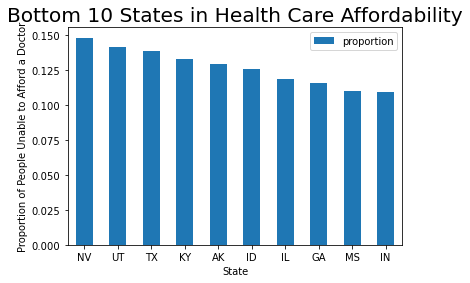

In [33]:
top_10_med = props_afford.head(10)
top_10_med.plot.bar(x = 'State_Code', y = 'proportion', rot = 0)

# Add a title to the plot and label axes
plt.style.use('fivethirtyeight')
plt.title("Bottom 10 States in Health Care Affordability")
plt.xlabel('State')
plt.ylabel('Proportion of People Unable to Afford a Doctor', size = 10)

Text(0, 0.5, 'Proportion of People Unable to Afford a Doctor')

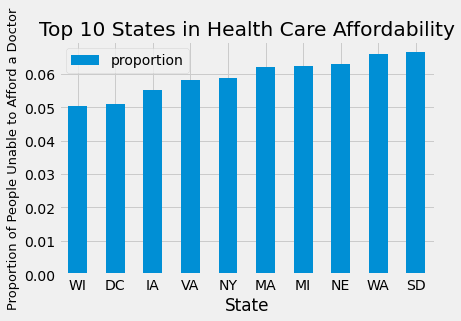

In [34]:
bot_10_med = props_afford.tail(10).sort_values('proportion', ascending = True)
bot_10_med.plot.bar(x = 'State_Code', y = 'proportion', rot = 0)

# Add a title to the plot and label axes
plt.style.use('fivethirtyeight')
plt.title("Top 10 States in Health Care Affordability")
plt.xlabel('State')
plt.ylabel('Proportion of People Unable to Afford a Doctor', size = 13)

From these graphs, we can see that Nevada, Utah, and Texas are the worst states in health care affordability with Wisconscin, DC, and Iowa being the best states for health care affordability.

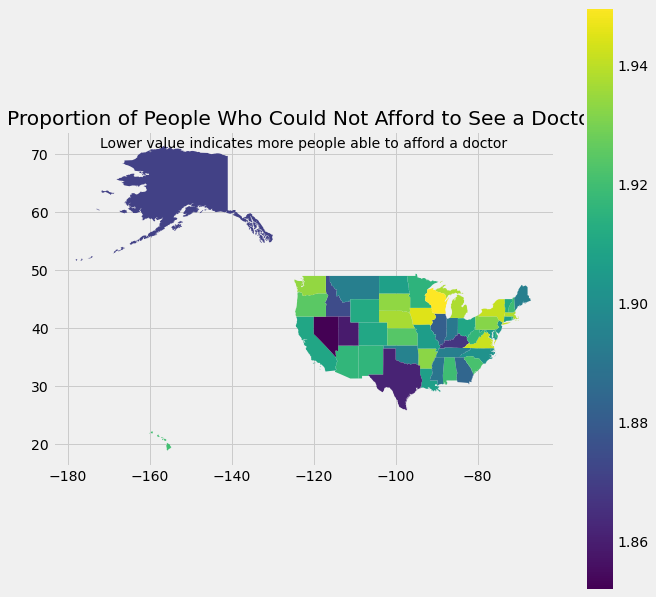

In [35]:
fig, ax = plt.subplots(figsize=(10, 10))

map_means.plot(ax=ax,column='MEDCOST1',legend=True)

# Add a title to the plot
plt.title('Proportion of People Who Could Not Afford to See a Doctor')
plt.text(0.5, 0.95, 'Lower value indicates more people able to afford a doctor', transform=ax.transAxes, ha='center')

# Display the plot
plt.show()

From this graph, there seems to be a greater amount of people having issues with being able to afford medical care through doctor's visits in primarily the Midwest and Northeast United States.

### Proportion of People Exercising Within Last Month

In [36]:
# Calculating Proportions of People not Exercising within Last Month
props_exer = props.groupby('State_Code')['EXERANY2'].value_counts(normalize = True).to_frame()
props_exer.columns = ['proportion']
props_exer = props_exer.reset_index()
props_noexer = props_exer[props_exer['EXERANY2'] == 1]
props_noexer = props_noexer.sort_values('proportion', ascending = False)
props_noexer.head()

,State_Code,EXERANY2,proportion
14,DC,1.0,0.840836
10,CO,1.0,0.833870
90,VT,1.0,0.829617
20,HI,1.0,0.824984
92,WA,1.0,0.817822


Text(0, 0.5, 'Proportion of People with No Exercise in the Last 30 Days')

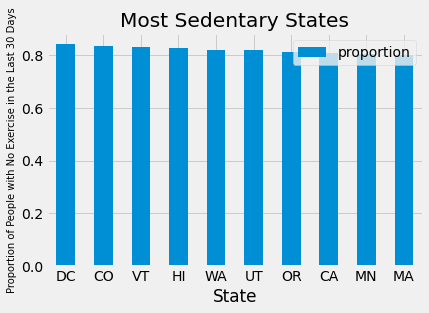

In [37]:
top_10_exer = props_noexer.head(10)
top_10_exer.plot.bar(x = 'State_Code', y = 'proportion', rot = 0)

# Add a title to the plot and label axes
plt.style.use('fivethirtyeight')
plt.title("Most Sedentary States")
plt.xlabel('State')
plt.ylabel('Proportion of People with No Exercise in the Last 30 Days', size = 10)

Text(0, 0.5, 'Proportion of People with No Exercise in the Last 30 Days')

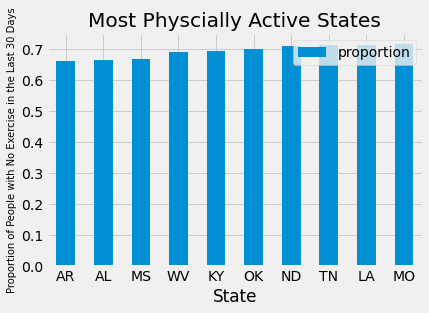

In [38]:
bot_10_exer = props_noexer.tail(10).sort_values('proportion', ascending = True)
bot_10_exer.plot.bar(x = 'State_Code', y = 'proportion', rot = 0)

# Add a title to the plot and label axes
plt.style.use('fivethirtyeight')
plt.title("Most Physcially Active States")
plt.xlabel('State')
plt.ylabel('Proportion of People with No Exercise in the Last 30 Days', size = 10)

From these graphs, we can see that a majority of the population remains sedentary with Arkansas, the state with the most physically active population, hovering around 30%. Furhtermore relative to other states, DC, Colorado, and Vermont have the most sedentary lifestyles. Finally, Arkansas, Alaska, and Missouri were the most physically active states.

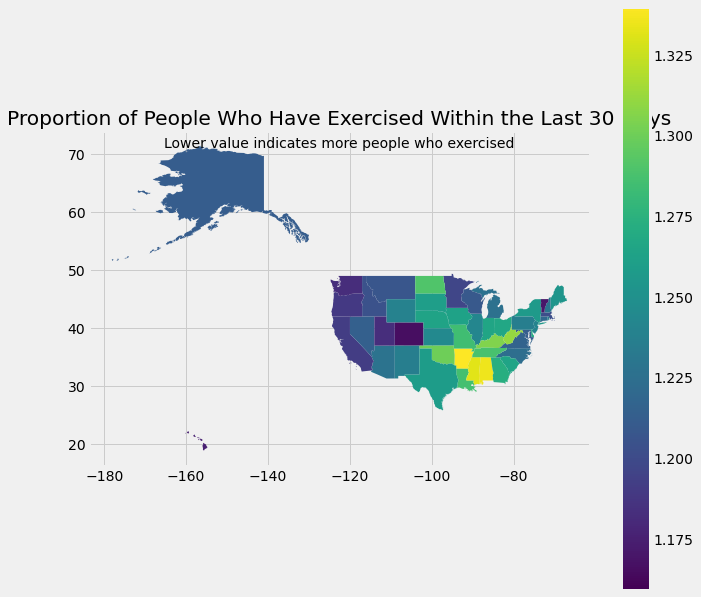

In [39]:
fig, ax = plt.subplots(figsize=(10, 10))

map_means.plot(ax=ax,column='EXERANY2',legend=True)

# Add a title to the plot
plt.title('Proportion of People Who Have Exercised Within the Last 30 Days')
plt.text(0.5, 0.95, 'Lower value indicates more people who exercised', transform=ax.transAxes, ha='center')

# Display the plot
plt.show()

Most states appear to have a greater proportion of people who have exercised within the last 30 days, with a noticeable inconsistency in the South--particularly in Alabama, Mississippi, and Arkansas having a much greater value than other states. This indicates lower average exercise for surveyed people in this specific region than most states.

### Out of People Who Used Marijuana, Average Number of Days Used Within Last Month

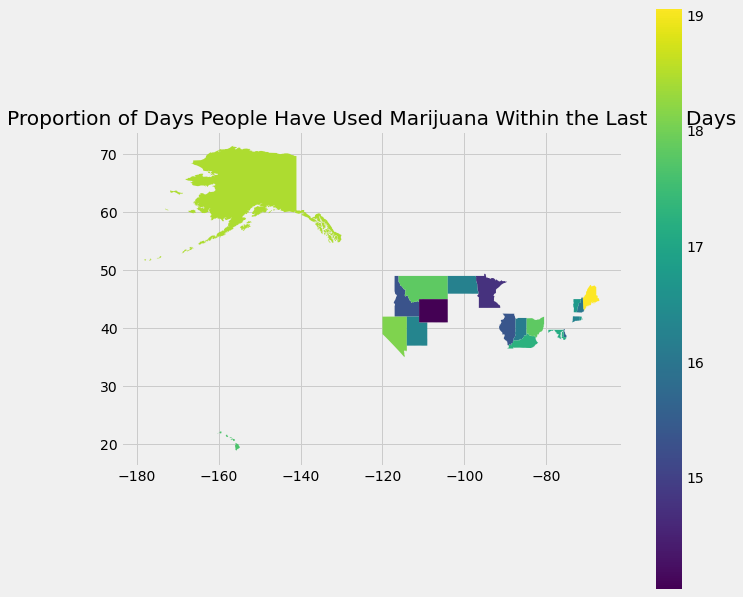

In [40]:
fig, ax = plt.subplots(figsize=(10, 10))

map_means.plot(ax=ax,column='MARIJAN1',legend=True)

# Add a title to the plot
plt.title('Proportion of Days People Have Used Marijuana Within the Last 30 Days')

# Display the plot
plt.show()

Out of people surveyed, only a small proportion of states had responses for marijuana use. Out of states with available data, Maine and Alaska have noteably much higher marijuana use per month on average than other visible states.

### Average Number of Drinks per Day Drinking

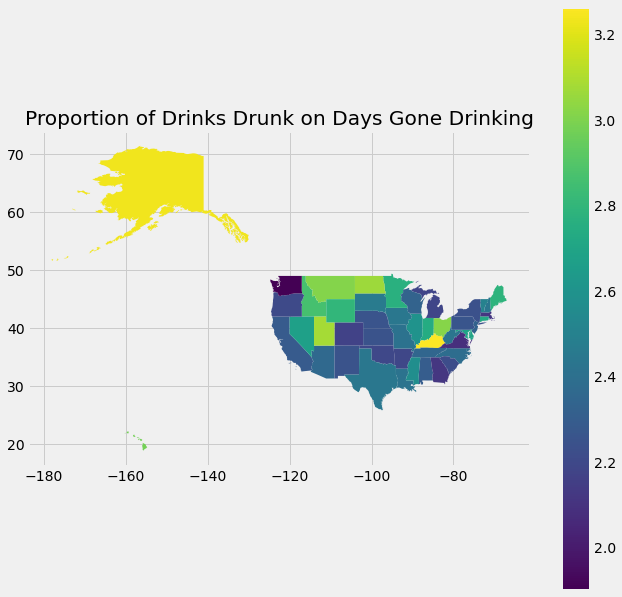

In [41]:
fig, ax = plt.subplots(figsize=(10, 10))

map_means.plot(ax=ax,column='AVEDRNK3',legend=True)

# Add a title to the plot
plt.title('Proportion of Drinks Drunk on Days Gone Drinking')

# Display the plot
plt.show()

Alaska and Kentucky have much higher average number of drinks drinken per day gone drinking than any other state. The (central) North United States appears to have higher general trend of average drinks than other areas of the United States.

### Proportion of General Smoking Consistency

In [42]:
# Calculating Proportions of People not Exercising within Last Month
props_smoke = props.groupby('State_Code')['SMOKDAY2'].value_counts(normalize = True).to_frame()
props_smoke.columns = ['proportion']
props_smoke = props_smoke.reset_index()
props_smokers = props_smoke[props_smoke['SMOKDAY2'] == 1]
props_smokers = props_smokers.sort_values('proportion', ascending = False)
props_smokers.head(10)

,State_Code,SMOKDAY2,proportion
48,KY,1.0,0.454780
103,OH,1.0,0.378378
43,IN,1.0,0.372951
1,AK,1.0,0.353459
82,ND,1.0,0.351421
61,ME,1.0,0.332664
76,MT,1.0,0.323970
37,ID,1.0,0.319048
40,IL,1.0,0.318452
145,WV,1.0,0.317433


Text(0, 0.5, 'Proportion of People Smoking Everyday')

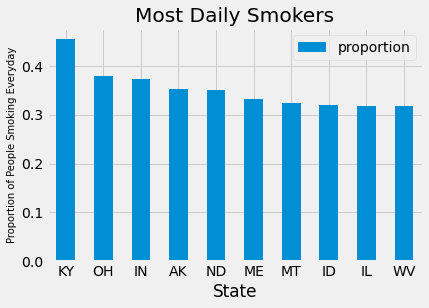

In [43]:
top_10_smokers = props_smokers.head(10)
top_10_smokers.plot.bar(x = 'State_Code', y = 'proportion', rot = 0)

# Add a title to the plot and label axes
plt.style.use('fivethirtyeight')
plt.title("Most Daily Smokers")
plt.xlabel('State')
plt.ylabel('Proportion of People Smoking Everyday', size = 10)

Text(0, 0.5, 'Proportion of People Smoking Everyday')

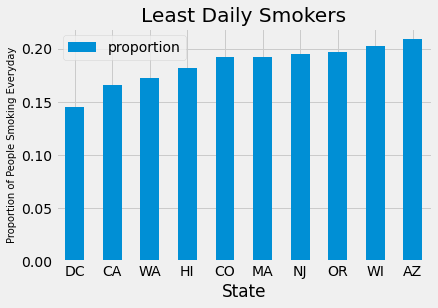

In [44]:
bot_10_smokers = props_smokers.tail(10).sort_values('proportion', ascending = True)
bot_10_smokers.plot.bar(x = 'State_Code', y = 'proportion', rot = 0)

# Add a title to the plot and label axes
plt.style.use('fivethirtyeight')
plt.title("Least Daily Smokers")
plt.xlabel('State')
plt.ylabel('Proportion of People Smoking Everyday', size = 10)

From these graphs, we can see that Kentucky is a bit of an outlier with more than 45% of the population smoking everyday with the rest of the states falling between 14-38%. Since smoking is a contributing factor to many cardiovascular and respiratory illnesses, the amount of smokers in a state should be indicative of that state's general health outlook.

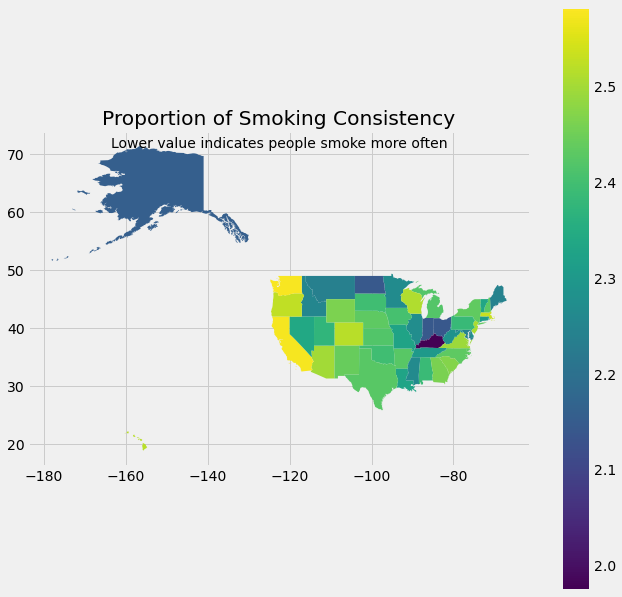

In [45]:
fig, ax = plt.subplots(figsize=(10, 10))

map_means.plot(ax=ax,column='SMOKDAY2',legend=True)

# Add a title to the plot
plt.title('Proportion of Smoking Consistency')
plt.text(0.5, 0.95, 'Lower value indicates people smoke more often', transform=ax.transAxes, ha='center')

# Display the plot
plt.show()

The North and Midwest appear to have much greater rates of smoking than the rest of the United States, with Kentucky having the greatest rate of smoking.

### Average Education Levels

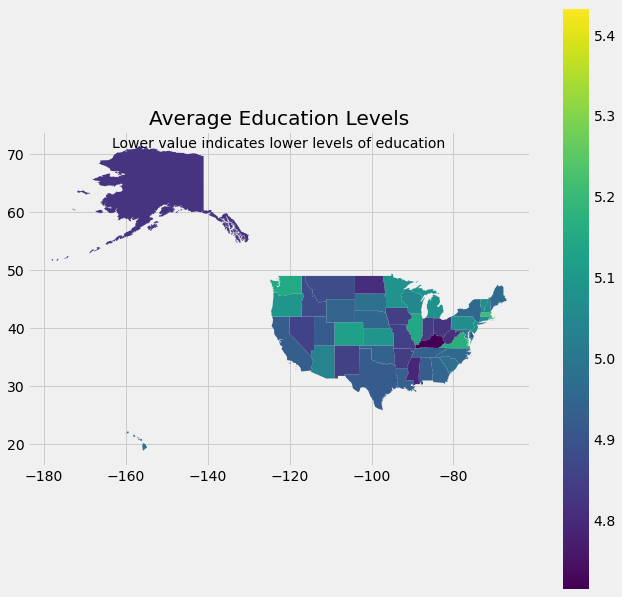

In [46]:
fig, ax = plt.subplots(figsize=(10, 10))

map_means.plot(ax=ax,column='EDUCA',legend=True)

# Add a title to the plot
plt.title('Average Education Levels')
plt.text(0.5, 0.95, 'Lower value indicates lower levels of education', transform=ax.transAxes, ha='center')

# Display the plot
plt.show()

There is no noticeable outliers for average education level. Most states appear to be within the same general interval of average education.

## Data Analysis

### Developing a Health Index Utilizing PCA

In [47]:
# Averaging observations by state to reduce inertia
means = brfss_state.groupby('State_Name').mean().drop('_STATE',axis=1)
means.head()

,PRIMINSR,PERSDOC3,MEDCOST1,CHECKUP1,EXERANY2,BPMEDS,CHOLMED3,CVDINFR4,CVDCRHD4,CVDSTRK3,...,HAVEHEPC,HAVEHEPB,MEDSHEPB,HPVADVC4,TETANUS1,SHINGLE2,DRADVISE,CIMEMLOS,MARIJAN1,USEMRJN3
State_Name,,,,,,,,,,,,,,,,,,,,,
alabama,9.645288,1.542103,1.928665,1.361911,1.345332,1.114514,1.665932,1.959860,1.981021,1.958551,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
alaska,12.876570,1.835245,1.949026,1.748953,1.228291,1.293380,1.788946,1.988167,1.999636,1.980885,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.588151,1.549312
arizona,11.658250,1.628496,1.934860,1.530599,1.238971,1.228291,1.743327,1.969870,1.985170,1.972686,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
arkansas,10.907669,1.532390,1.952159,1.364110,1.360015,1.135896,1.637071,1.960164,1.987342,1.959605,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
california,11.116258,1.611284,1.917595,1.639050,1.193912,1.259740,1.770241,1.987676,1.994358,1.983964,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### PCA

In [48]:
# Impute missing values
imputer = SimpleImputer(strategy='mean')
df_imputed = pd.DataFrame(imputer.fit_transform(means), columns=means.columns)

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_imputed)

# Run PCA
pca = PCA()
pca.fit(data_scaled)

# Calculate cumulative explained variance ratio
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Determine the suitable number of components
n_components = np.argmax(cumulative_variance_ratio >= 0.95) + 1

print("Number of components:", n_components)

Number of components: 21


In [49]:
pca = PCA(n_components=21)
pca_result = pca.fit_transform(data_scaled)

# Create a new DataFrame with the PCA results
pca_df = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(n_components)])

# Print the PCA DataFrame
print(pca_df)

          PC1       PC2        PC3       PC4       PC5       PC6       PC7  \
0    7.016342  1.986123   0.166886  0.446807 -1.127145  0.717018  0.280657   
1   -3.515399 -3.901089  -0.706313 -3.072504  2.355876  1.574207 -3.929960   
2    0.364682  1.298225   0.236234 -2.130757 -1.591581  0.713195 -1.004402   
3    8.433929  2.807751   1.097998  2.167576  0.737139 -0.223916 -1.265137   
4   -4.345191 -0.967487  -0.289710 -4.462249 -3.769232  0.980714  0.269893   
5   -5.873784 -2.454268  -0.142250 -1.912352 -0.049915  0.443746 -0.581898   
6   -4.765981  0.993287   0.231447  1.936418 -1.213430  0.192717 -0.070684   
7    0.822136  3.118727   1.689199 -0.316632 -3.913042 -1.289007 -1.199112   
8   -8.673459  0.906575   0.113051  1.838448 -1.970879  0.376274  1.410677   
9    2.502880 -0.337631  13.866546 -1.244696  0.673388  1.638348  0.111111   
10  -4.191351  0.550593  -0.618370 -3.691503 -2.193803  0.924172  1.933147   
11   0.172119 -2.209920  -0.447367 -0.856532  1.940194  0.422150

HOWEVER, for the purpose of PCA classification with regards to our research problem, only PC1 is needed to create the index.

In [50]:
pca = PCA(n_components=1)
pca_result = pca.fit_transform(data_scaled)

# Storing scores/index to a list
pc1_scores = [score for sublist in pca_result.tolist() for score in sublist]
pc1_scores

[7.0163419163021805,
 -3.515398523905394,
 0.36468222137709133,
 8.433928627750069,
 -4.345191380805429,
 -5.873783920151823,
 -4.765980702634141,
 0.8221356450572822,
 -8.673458507674075,
 2.502880305343832,
 -4.191350826150988,
 0.17211891070012372,
 -1.9564811549267314,
 0.8864969283061163,
 -0.5773684188434702,
 0.520587785532347,
 8.475049225580248,
 4.6278845965564805,
 1.58640226043326,
 -2.767000767976065,
 -6.398738736931892,
 -0.028476170795630126,
 -3.4924132964601418,
 10.772561241359094,
 4.961668088954107,
 0.7543933164750399,
 1.0718346009473978,
 0.5730970767375891,
 0.01137150601582558,
 -6.351763804746762,
 1.075040183285683,
 -0.9438704457724457,
 -0.7577973894547733,
 2.1855059573069537,
 -3.515398523905398,
 3.6861714750898775,
 3.181306114583512,
 -3.963281084073817,
 -0.7057052077835796,
 -3.560734066305275,
 3.2195029984893955,
 0.36301385463983016,
 3.7439721223778433,
 -0.11454416739652734,
 -4.761140086815654,
 -4.631862288024724,
 -4.771950296429193,
 -2.586

#### Examining the Index

In [54]:
# Placing PC scores/index into dataframe
index_df = pd.DataFrame()
means.reset_index(inplace=True)
index_df['State_Name'], index_df['health_index'] = means['State_Name'], pc1_scores
index_df.head()

,State_Name,health_index
0,alabama,7.016342
1,alaska,-3.515399
2,arizona,0.364682
3,arkansas,8.433929
4,california,-4.345191


In [56]:
# Top 10 index score states
index_df.nlargest(10, 'health_index')

,State_Name,health_index
23,mississippi,10.772561
48,west virginia,9.880370
16,kentucky,8.475049
3,arkansas,8.433929
0,alabama,7.016342
24,missouri,4.961668
17,louisiana,4.627885
42,tennessee,3.743972
35,ohio,3.686171
40,south carolina,3.219503


The states with the "highest" health index scores are in order as follows:
- Mississippi
- West Virginia
- Kentucky
- Arkansas
- Alabama

In [57]:
# Low 10 index score states
index_df.nsmallest(10, 'health_index')

,State_Name,health_index
8,district of columbia,-8.673459
20,massachusetts,-6.398739
29,new jersey,-6.351764
5,colorado,-5.873784
46,virginia,-4.771950
6,connecticut,-4.765981
44,utah,-4.761140
45,vermont,-4.631862
4,california,-4.345191
10,hawaii,-4.191351


The states with the "lowest" health index scores are in order as follows:
- (Washington DC)
- Massachusetts
- New Jersey
- Colorado
- Virginia
- Connecticut

In [58]:
# Merging to map data to plot
index_df = map_means.merge(index_df, on='State_Name')

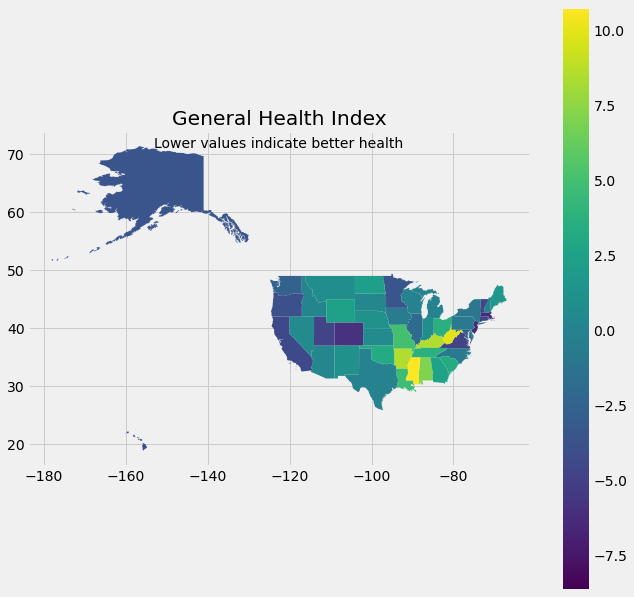

In [59]:
fig, ax = plt.subplots(figsize=(10, 10))

index_df.plot(ax=ax,column='health_index',legend=True)

# Add a title to the plot
plt.title('General Health Index')
plt.text(0.5, 0.95, 'Lower values indicate better health', transform=ax.transAxes, ha='center')

# Display the plot
plt.show()

Noteably, the South and parts of the Midwest appear to have the highest index scores, indicating generally lower levels of general health compared to the rest of the United States.

# Ethics & Privacy

There are no real concerns of any issues of privacy or terms with the data proposed as it is published transparently by the United States government for general public access and use. However, there is potential bias in the datasets as it relies on surveyed data. Based on the topics at hand of health and socioeconomic data, respondents may have chosen not to respond to certain questions or provided inaccurate information (such as lying about certain health statuses, income levels, etc.). Furthermore, there is potential for an imbalance in data from different states due to general population levels and/or number of individuals interested in responding to certain surveys over time.

To address some of these issues, the data will be standardized and/or scaled as necessary based on states/populations versus number of respondents as well as cleaning up the dataset for any non-responses. For responses that are possible, mean values may and could be used to substitute missing values to help even out the overall number of observations to be used for analysis and prediction modeling.

# Conclusion & Discussion

According to results from 'Americas Health Rankings,' the healthiest states (in order) are: New Hampshire, Massachusetts, Vermont, Connecticut, and Hawaii. Their model also determines the worst states being Louisiana, Mississippi, Arkansas, West Virginia, and Alabama. Based on this index and other research, the PCA index can be interpreted with lower values indicating greater general health and higher values indicating lower or worsened health on average. With this, the PCA model had the following outcomes:
- Best States: (Washington DC), Massachusetts, New Jersey, Colorado, Virginia, Connecticut
- Worst States: Mississippi, West Virginia, Kentucky, Arkansas, Alabama

On initial comparison, the index/model only had 1/5 best states overlap with other indeces, however 3 of them (Hawaii, Vermont, and Connecticut) had very similar index scores (difference less than 1) indicating a general similar trend for the healthiest states. As for the worst states, 4/5 overlapped with the exception of Louisiana which placed better on this scale as the 7th worst state in terms of general health instead of number 1.

From this, it can be concluded that the BRFSS survey data from the CDC does do a relatively good job at properly monitoring and assessing general health of both individuals and states when compared to other models that utilize different forms or greater variety in questions, conditions, etc. While there is no definitive method/ranking of general health across US states, the similarity in trends across different research and data sources/types does generally point to these states following the trends indicated in the data analysis and ranking.